4.1 Sesssion overview

This is a further clarrification and work related to the churn prediction.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data_churm_project.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter= len(X_train)*10)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,42250
,multi_class,'deprecated'


In [ ]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

4.2 Accuracy and dummy model

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [ ]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.734
0.30 0.758
0.35 0.765
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


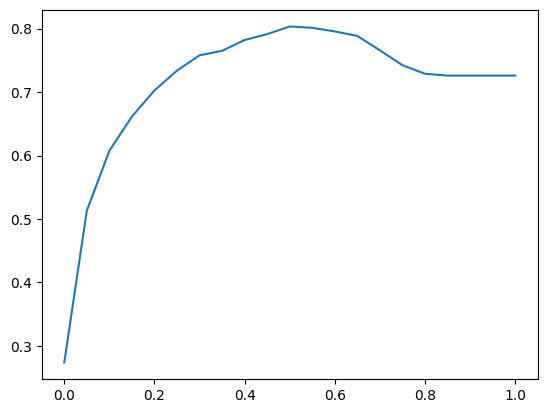

In [ ]:
plt.plot(thresholds, scores)

In [13]:
from collections import Counter
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [14]:
y_val.mean()

np.float64(0.2739531582682754)

For the last two cells, there is no churn prediction that have the value of 1.

But if we evaluate the churn for the validation dataset, 27% of the values are 1. There is a class inbalance in the churn values.

4.3 Confusion Matrix

The goal is to dive into the diferent errors that your binary classifcation did.

True_Positive; Fasle_Positive; True_Negative; Fasle_Negative.

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [16]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [18]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

#TN;FP
#FN;TP

array([[920, 103],
       [174, 212]])

In [19]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

4.4 Precision and Recall

In [21]:
p = tp / (tp + fp)
print(p)
print(1-p)

0.6730158730158731
0.32698412698412693


32% of customer are not likely to churn but we din'd find them.

In [22]:
r = tp / (tp + fn)
print(r)
print(1-r)

0.5492227979274611
0.4507772020725389


45% of customer that are not churning is considered as churning. So they will profite our promotion.